# Week 1: Machine Learning in Cloud
One does not simply become a data scientist...

## Workshop Outline
<ul>
    <li>Step-by-step case study: Diabetes Prediction</li>
    <li><u>Machine Learning in Cloud</u></li>
</ul>

## Contents

1. [AWS Setup Configuration](#AWS-Setup-Configuration)
1. [Meet and Greet Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

## AWS Setup Configuration

This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).


In [1]:
bucket = 'aws-lta-workshop2020'
prefix = 'sagemaker/xgboost-ml-in-cloud'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Packages and Libraries

In [2]:
# standard libraries
import io, os, sys
import time, json
from time import strftime, gmtime

In [3]:
# data analytics module
import numpy as np
import pandas as pd

# visualisation module
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
# AWS sagemaker API
import sagemaker
from sagemaker.predictor import csv_serializer

## Data

The diabetes data set was originated from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes). This dataset describes the medical records for Pima Indians and whether or not each patient will have an onset of diabetes within five years. 

**Data Dictionary**
* `Pregnancies`: Number of times pregnant 
* `Glucose`: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
* `BloodPressure`: Diastolic blood pressure (mm Hg) 
* `SkinThickness`: Triceps skin fold thickness (mm) 
* `Insulin`: 2-Hour serum insulin (mu U/ml) 
* `BMI`: Body mass index (weight in kg/(height in m)^2) 
* `DiabetesPedigreeFunction`: Diabetes pedigree function 
* `Age`: Age (years) 
* `Outcome`: Class variable (0 or 1) 
 

In [5]:
PATH_TO_DATA = 'data/'
raw_data_path = os.path.join(PATH_TO_DATA, 'raw/diabetes.csv')

In [6]:
data = pd.read_csv(raw_data_path)

In [9]:
data.head(5) # take a look at the first 5 rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In the [previous workshop](#Week1_Diabetes_Prediction), we have seen many algorithms that we can use to make binary classification such as Random Forest and Gradient Boosting. Let's attempt to model this problem using gradient boosted trees.

Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [13]:
import numpy as np

# Split the dataset (X and Y) into training and testing sets
from sklearn.model_selection import train_test_split

X = data.loc[:, ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                 'BMI', 'DiabetesPedigreeFunction', 'Age']]
Y = data.loc[:, ['Outcome']]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1)

As mentioned, we will need to have the predictor/target variable in the first column in our dataset.

Here, the code below will concatenate back our predictor variable and place it as the first column in our dataset.

In [14]:
train_data = pd.concat([Y_train, X_train], axis=1)
validation_data = pd.concat([Y_val, X_val], axis=1)

We save the dataset that we have split into training and validation set into a *csv* format

In [15]:
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these csv files to S3 bucket

In [16]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


Then, because we're training with the CSV file format, we'll create a pointer to the files in S3.
We call this pointer `s3_input`

In [19]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [20]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.t2.medium',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=2,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-12-27 12:12:59 Starting - Starting the training job...
2019-12-27 12:13:01 Starting - Launching requested ML instances......
2019-12-27 12:14:02 Starting - Preparing the instances for training...
2019-12-27 12:14:59 Downloading - Downloading input data
2019-12-27 12:14:59 Training - Downloading the training image...
2019-12-27 12:15:26 Uploading - Uploading generated training modelArguments: train
[2019-12-27:12:15:21:INFO] Running standalone xgboost training.
[2019-12-27:12:15:21:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8517.95mb
[2019-12-27:12:15:21:INFO] Determined delimiter of CSV input is ','
[12:15:21] S3DistributionType set as FullyReplicated
[12:15:21] 691x8 matrix with 5528 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-12-27:12:15:21:INFO] Determined delimiter of CSV input is ','
[12:15:21] S3DistributionType set as FullyReplicated
[12:15:21] 77x8 matrix with 616 entries loaded 


2019-12-27 12:15:32 Completed - Training job completed
Training seconds: 45
Billable seconds: 45


## Compile
[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to twice as fast, with no loss in accuracy. When calling `compile_model()` function, we specify the target instance family (m4) as well as the S3 bucket to which the compiled model would be stored.

In [21]:
compiled_model = xgb
try:
    xgb.create_model()._neo_image_account(boto3.Session().region_name)
except:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m4', 
                                   input_shape={'data':[1, 69]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='0.7',
                                   output_path=output_path)
    compiled_model.name = 'deployed-xgboost-diabetes'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')

?..!

## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [24]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')

---------------------------------------------------------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [25]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer  # sagemaker.predictor.csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [50]:
def predict(data, rows=20):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(validation_data.as_matrix()[:, 1:])
y_pred = predictions > 0.5

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Confusion Matrix

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment = "center",
        color = "white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

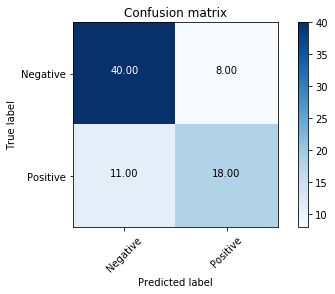

In [54]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_val, y_pred)
plot_confusion_matrix(confusion_matrix, classes=["Negative", "Positive"])

### ROC AUC

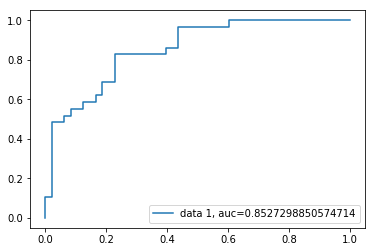

In [58]:
fpr, tpr, _ = metrics.roc_curve(Y_val,  predictions)
auc = metrics.roc_auc_score(Y_val, predictions)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()